# ***Major League Cricket Data Analysis***
### by [***Anthahkarana***](https://anthahkarana.tech)

### **2024 SEASON**
Same queries as the previous notebook titled 'Initial Analysis'

Defining the Folder Path where I have uploaded the ball-by-ball database of every MLC match. Credits to [CricSheet](https://cricsheet.org)

In [1]:
folder_path='/content/mlc_json'

All the JSON files by cricsheet are well-defined with comprehensive data. Some of them just need to be connected in order to perform further analysis. Here, I am map each player to their respective team.

In [48]:
import os
import json


# Dictionary to store player-to-team mappings across all files
team_mapping = {}

# Process each JSON file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):  # Process only JSON files
        file_path = os.path.join(folder_path, filename)

        # Load the JSON data
        with open(file_path, 'r') as file:
            match_data = json.load(file)

        # Extract players and registry data
        players_data = match_data.get('info', {}).get('players', {})
        registry_data = match_data.get('info', {}).get('registry', {}).get('people', {})

        # Create the player-to-team mapping for this file
        for team, players in players_data.items():
            for player_short_name in players:
                for full_player_name, player_id in registry_data.items():
                    if player_short_name == full_player_name:
                        team_mapping[full_player_name] = team
                        break

# Print the resulting dictionary
print(team_mapping)


{'Q de Kock': 'Seattle Orcas', 'Nauman Anwar': 'Seattle Orcas', 'GSNFG Jayasuriya': 'Seattle Orcas', 'H Klaasen': 'Seattle Orcas', 'SO Hetmyer': 'Seattle Orcas', 'Shubham Ranjane': 'Seattle Orcas', 'Imad Wasim': 'Seattle Orcas', 'CJ Gannon': 'Seattle Orcas', 'WD Parnell': 'Seattle Orcas', 'Harmeet Singh': 'Seattle Orcas', 'AJ Tye': 'Seattle Orcas', 'MS Wade': 'San Francisco Unicorns', 'FH Allen': 'San Francisco Unicorns', 'MP Stoinis': 'Texas Super Kings', 'AJ Finch': 'San Francisco Unicorns', 'CJ Anderson': 'San Francisco Unicorns', 'Shadab Khan': 'San Francisco Unicorns', 'Tajinder Singh': 'San Francisco Unicorns', 'Chaitanya Bishnoi': 'San Francisco Unicorns', 'LE Plunkett': 'San Francisco Unicorns', 'Haris Rauf': 'San Francisco Unicorns', 'C le Roux': 'San Francisco Unicorns', 'JJ Roy': 'Los Angeles Knight Riders', 'SP Narine': 'Los Angeles Knight Riders', 'UBT Chand': 'Los Angeles Knight Riders', 'Shakib Al Hasan': 'Los Angeles Knight Riders', 'NR Kumar': 'Los Angeles Knight Rider

Now, finding the top run-scorers in the 2024 edition of MLC.

In [47]:
import pandas as pd
import glob
import os
import json


all_files = glob.glob(os.path.join(folder_path, "*.json"))

player_runs2024 = {}  # Store total runs for each player

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    # Assuming player information is under 'info' and then 'players'
    registry = match_data.get('info', {}).get('players', {})

    # Iterating through innings and deliveries to accumulate runs
    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):  # Assuming overs are under 'overs'
            for delivery in over.get('deliveries', []):
                batter_name = delivery.get('batter')
                runs_scored = delivery.get('runs', {}).get('batter', 0)

                # Get player name from registry if not directly available
                # Change: Check if batter_name is in the list of players for the team
                # and get the corresponding full name (or ID if names are not available)
                if batter_name not in registry and batter_name in registry.get(inning.get('team'), []):
                    # Use index to access element from list:
                    batter_name = registry.get(inning.get('team'))[registry.get(inning.get('team')).index(batter_name)]

                if batter_name:
                    player_runs2024[batter_name] = player_runs2024.get(batter_name, 0) + runs_scored

Now, we have the total number of runs scored by each player in the MLC. Moving onto sorting the top ten players.

In [46]:
# Sort players by total runs in descending order
sorted_players = sorted(player_runs2024.items(), key=lambda item: item[1], reverse=True)

# Get the top ten run scorers
top_ten_scorers = sorted_players[:10]

# Print the top ten run scorers
print("Top Ten Run Scorers of MLC 2024:")
for player, runs in top_ten_scorers:
    print(f"{player}: {runs} runs")

Top Ten Run Scorers of MLC 2024:
F du Plessis: 420 runs
TM Head: 336 runs
SPD Smith: 336 runs
FH Allen: 306 runs
DP Conway: 293 runs
RD Rickelton: 225 runs
Hassan Khan: 204 runs
N Pooran: 180 runs
MW Short: 170 runs
Q de Kock: 170 runs


Now, displaying them in a bar graph using Seaborn and MatPlotLib (Pandas is used to create a dataframe as seen below)..

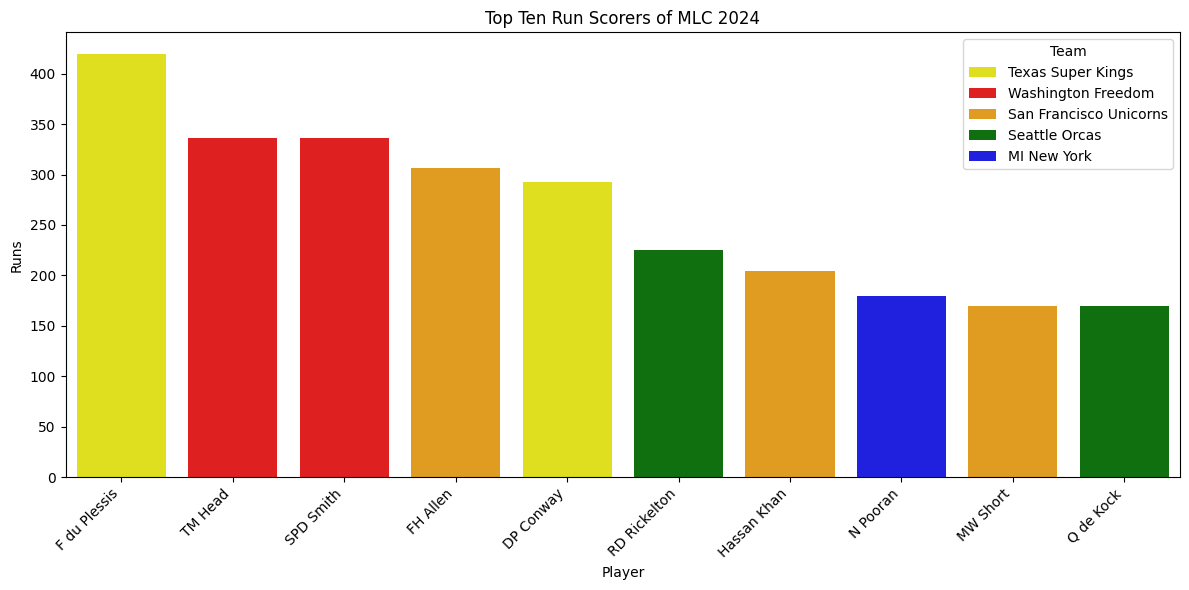

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with Player, Runs, and Team columns
top_ten_scorers_df = pd.DataFrame(top_ten_scorers, columns=['Player', 'Runs'])
top_ten_scorers_df['Team'] = top_ten_scorers_df['Player'].map(team_mapping)

# Define a color palette for the teams
team_colors = {
    'MI New York': 'blue',
    'Seattle Orcas': 'green',
    'Texas Super Kings': 'yellow',
    'San Francisco Unicorns': 'orange',
    'Los Angeles Knight Riders': 'purple',
    'Washington Freedom': 'red'
}

# Create the bar plot with hue='Team'
plt.figure(figsize=(12, 6))
sns.barplot(x='Player', y='Runs', hue='Team', data=top_ten_scorers_df, palette=team_colors)
plt.title('Top Ten Run Scorers of MLC 2024')
plt.xlabel('Player')
plt.ylabel('Runs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Notice that Los Angeles Knight Riders don't have a single player in this list, perhaps explaining their inability to qualify for playoffs..

Now, calculating the highest run-scorers against spin specifically..

In [44]:
# Load necessary data
people_df = pd.read_csv('people.csv')
comprehensive_df = pd.read_csv('comprehensive.csv')
all_files = glob.glob(os.path.join(folder_path, "*.json"))

# Create a dictionary to map player identifiers to bowling types
player_bowling_type = dict(zip(comprehensive_df['identifier'], comprehensive_df['Bowling Type']))

# Create a dictionary to store runs against spin for each player
runs_against_spin = {}

# Process JSON files to calculate runs against spin
for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                batter_name = delivery.get('batter')
                bowler_name = delivery.get('bowler')
                runs_scored = delivery.get('runs', {}).get('batter', 0)

                # Get identifiers for batter and bowler
                batter_identifier = registry.get(batter_name)
                bowler_identifier = registry.get(bowler_name)

                # Check if bowler is a spin bowler AND batter and bowler are in our data
                if bowler_identifier in player_bowling_type and player_bowling_type[bowler_identifier] == 'spin' and batter_identifier in player_bowling_type:
                    runs_against_spin[batter_name] = runs_against_spin.get(batter_name, 0) + runs_scored

# Find the highest run scorer against spin
sorted_players_against_spin = sorted(runs_against_spin.items(), key=lambda item: item[1], reverse=True)

# Get the top ten run scorers against spin
top_ten_against_spin = sorted_players_against_spin[:10]


Similar Bar Graph to visualize this data..

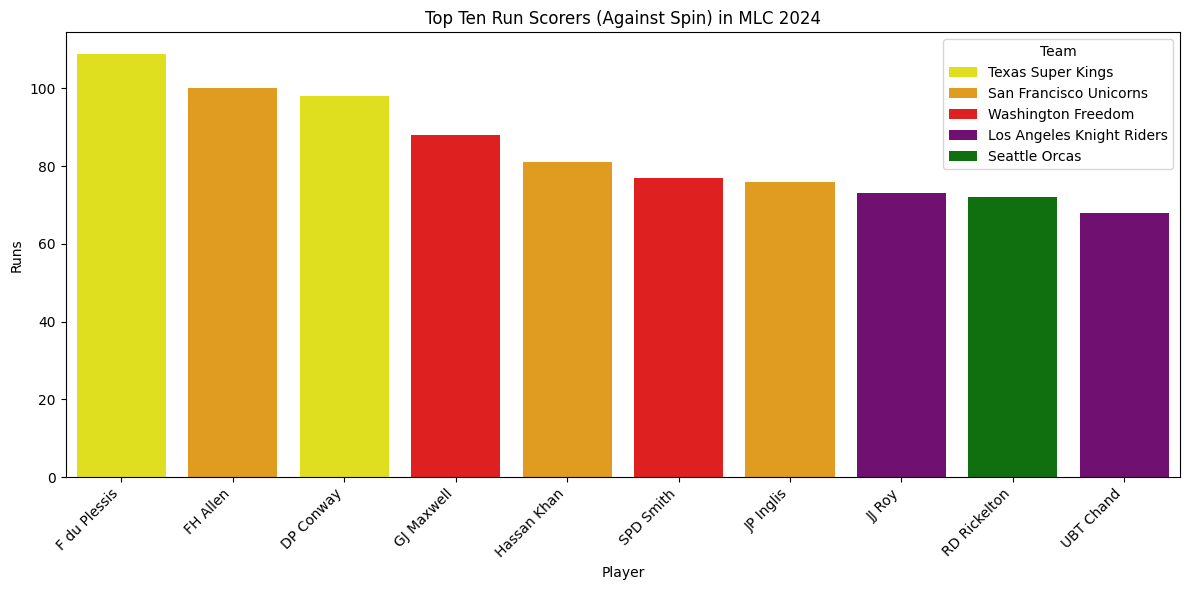

In [43]:
# Create a DataFrame with Player, Runs, and Team columns
top_ten_spin_df = pd.DataFrame(top_ten_against_spin, columns=['Player', 'Runs'])
top_ten_spin_df['Team'] = top_ten_spin_df['Player'].map(team_mapping)

#Team Colors have been assigned in the previous graph itself

# Create the bar plot with hue='Team'
plt.figure(figsize=(12, 6))
sns.barplot(x='Player', y='Runs', hue='Team', data=top_ten_spin_df, palette=team_colors)
plt.title('Top Ten Run Scorers (Against Spin) in MLC 2024')
plt.xlabel('Player')
plt.ylabel('Runs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Although Faf Du Plessis leads this chart, Devon Conway is still in the top three establishing his craft to play spin..

Now, we are trying to find the batsmen who have been succumbed to spin the most number of times in the 2023 season..

In [12]:
dismissals_against_spin = {}  # Store dismissals against spin for each player

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                # Check if there are any wickets in the delivery
                if 'wickets' in delivery:
                    for wicket in delivery['wickets']:
                        batter_name = wicket.get('player_out')
                        kind = wicket.get('kind')

                        if batter_name and kind != 'run out':
                            bowler_name = delivery.get('bowler')

                            # Get identifiers for batter and bowler
                            batter_identifier = registry.get(batter_name)
                            bowler_identifier = registry.get(bowler_name)

                        if bowler_identifier in player_bowling_type and player_bowling_type[bowler_identifier] == 'spin' and batter_identifier in player_bowling_type:
                          dismissals_against_spin[batter_name] = dismissals_against_spin.get(batter_name, 0) + 1

We have the data now, sorting and printing below..

In [42]:
# Find the players with the most dismissals against spin
sorted_players_by_dismissals = sorted(dismissals_against_spin.items(), key=lambda item: item[1], reverse=True)

# Get the top ten players
top_ten_dismissals_against_spin = sorted_players_by_dismissals[:10]

# Print the results
print("Top Ten Players with Most Dismissals Against Spin in MLC 2024:")
for player, dismissals in top_ten_dismissals_against_spin:
    print(f"{player}: {dismissals} dismissals")

Top Ten Players with Most Dismissals Against Spin in MLC 2024:
FH Allen: 5 dismissals
AM Hardie: 4 dismissals
Shakib Al Hasan: 3 dismissals
MW Short: 3 dismissals
H Klaasen: 3 dismissals
SP Krishnamurthi: 3 dismissals
MD Patel: 3 dismissals
GJ Maxwell: 3 dismissals
Haris Rauf: 3 dismissals
Hassan Khan: 3 dismissals


Although Finn Allen is one of the more profilic run-scorers against spin (as we saw in our previous graph), he has been dismissed 5 times, high risk high reward!!

Now we look towards finding the spinners who have managed to successfully rattled the stumps for the highest number of times

In [14]:
bowled_dismissal = {}  # Store dismissals against spin for each player

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                # Check if there are any wickets in the delivery
                if 'wickets' in delivery:
                    for wicket in delivery['wickets']:
                        batter_name = wicket.get('player_out')
                        kind = wicket.get('kind')

                        if kind == 'bowled': #Filter for bowled dismissals
                            bowler_name = delivery.get('bowler')
                            bowler_identifier = registry.get(bowler_name)

                            if bowler_identifier in player_bowling_type and player_bowling_type[bowler_identifier] == 'spin':
                              bowled_dismissal[bowler_name] = bowled_dismissal.get(bowler_name, 0) + 1

In [41]:
# We have the data now, sorting and printing below..
sorted_bowled = sorted(bowled_dismissal.items(), key=lambda item: item[1], reverse=True)

# Get the top ten players
top_ten_sorted = sorted_bowled[:10]

# Print the results
print("Top Ten Spinners with Most Bowled Dismissals in MLC 2024:")
for player, dismissals in top_ten_sorted:
    print(f"{player}: {dismissals} dismissals")

Top Ten Spinners with Most Bowled Dismissals in MLC 2024:
Rashid Khan: 4 dismissals
Noor Ahmad: 4 dismissals
Mohammad Mohsin: 3 dismissals
GJ Maxwell: 3 dismissals
SP Narine: 2 dismissals
R Ravindra: 2 dismissals
Hassan Khan: 1 dismissals
Imad Wasim: 1 dismissals
AJ Hosein: 1 dismissals
NP Kenjige: 1 dismissals


Afghan Spinners Rashid and Noor lead the charts this time around, with Mohammad Mohsin maintaining his consistency from last season..

Now let's try to do something a bit more complex. Let's start with finding the top wicket scorers of MLC 2024..

In [18]:
wickets_by_bowler = {}

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                if 'wickets' in delivery:
                    for wicket in delivery['wickets']:
                        bowler_name = delivery.get('bowler')
                        kind = wicket.get('kind')  # Extract kind of dismissal

                        if kind != 'run out':  # Exclude run outs
                            bowler_identifier = registry.get(bowler_name)

                            # Assuming we need to check for the bowler type (optional check for spin)
                            if bowler_identifier:  # Ensure bowler exists in the registry
                                wickets_by_bowler[bowler_name] = wickets_by_bowler.get(bowler_name, 0) + 1

# Sort bowlers by wickets in descending order
sorted_bowlers = sorted(wickets_by_bowler.items(), key=lambda item: item[1], reverse=True)

# Get the top ten bowlers
top_ten_bowlers = sorted_bowlers[:10]

# Print the top ten bowlers
print("Top Ten Bowlers with Highest Number of Wickets in MLC 2024:")
for player, wickets in top_ten_bowlers:
    print(f"{player}: {wickets} wickets")


Top Ten Bowlers with Highest Number of Wickets in MLC 2024:
SN Netravalkar: 15 wickets
R Ravindra: 12 wickets
CJ Gannon: 11 wickets
M Jansen: 11 wickets
Hassan Khan: 10 wickets
Rashid Khan: 10 wickets
GJ Maxwell: 10 wickets
LH Ferguson: 10 wickets
SH Johnson: 9 wickets
TA Boult: 9 wickets


We can see Netravalkar rising up the ranks, with Boult being a lot less lethal than his record 2023 season. Cameron Gannon has astonishingly maintained his consistency..

In [40]:
# Initialize the dictionary to store dismissal counts for each bowler
top_ten_bowler_dismissals = {}

# List of all possible dismissal types
dismissal_kinds = [
    'bowled', 'caught', 'caught and bowled', 'lbw', 'stumped',
    'run out', 'retired hurt', 'hit wicket', 'obstructing the field',
    'hit the ball twice', 'handled the ball', 'timed out'
]

# Initialize dismissal kinds for each bowler
for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for bowler_name, _ in top_ten_bowlers:  # Iterate through the top 10 bowlers
        if bowler_name not in top_ten_bowler_dismissals:
            top_ten_bowler_dismissals[bowler_name] = {kind: 0 for kind in dismissal_kinds}  # Initialize all dismissal types for each bowler

        for inning in match_data.get('innings', []):
            for over in inning.get('overs', []):
                for delivery in over.get('deliveries', []):
                    if 'wickets' in delivery:
                        for wicket in delivery['wickets']:
                            current_bowler_name = delivery.get('bowler')
                            if current_bowler_name == bowler_name:
                                kind = wicket.get('kind')
                                if kind and kind in top_ten_bowler_dismissals[bowler_name]:
                                    top_ten_bowler_dismissals[bowler_name][kind] += 1

Code_To_Print_This = """
for bowler, dismissals in top_ten_bowler_dismissals.items():
    print(f"Dismissals for {bowler}:")
    for dismissal_kind, count in dismissals.items():
        print(f"  {dismissal_kind}: {count}")
"""


And let's visualize this on a bar graph!

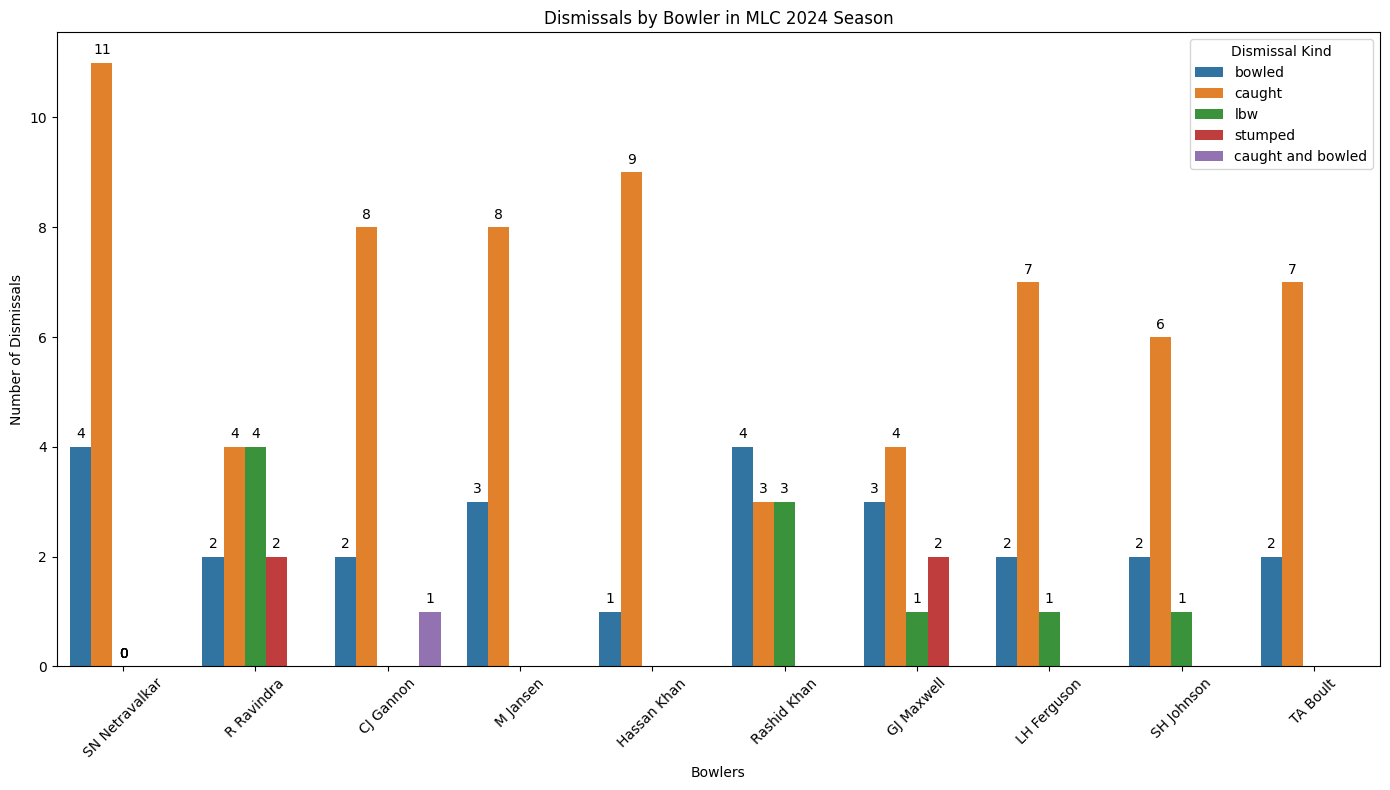

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Dismissal kinds as defined earlier (which have at least one dismissal)
dismissal_kinds = [
    'bowled', 'caught', 'caught and bowled', 'lbw', 'stumped'
]

# Prepare the data for plotting
bowler_names = list(top_ten_bowler_dismissals.keys())
dismissal_counts = []

# Create a list of dismissal counts for each bowler, excluding zero counts
for bowler in bowler_names:
    counts = [top_ten_bowler_dismissals[bowler].get(kind, 0) for kind in dismissal_kinds]
    for i, kind in enumerate(dismissal_kinds):
        if counts[i] > 0:  # Only add dismissal kinds with non-zero counts
            dismissal_counts.append({
                'Bowler': bowler,
                'Dismissal Kind': kind,
                'Count': counts[i]
            })

# Convert to DataFrame
df_dismissals = pd.DataFrame(dismissal_counts)

# Create the seaborn plot
plt.figure(figsize=(14, 8))

# Use seaborn's barplot to create the bar chart
ax = sns.barplot(x='Bowler', y='Count', hue='Dismissal Kind', data=df_dismissals)

# Set labels and title
plt.xlabel('Bowlers')
plt.ylabel('Number of Dismissals')
plt.title('Dismissals by Bowler in MLC 2024 Season')

# Rotate the x-axis labels to avoid overlap
plt.xticks(rotation=45)

# Calculate the total dismissals for each bowler and display on top of the bars
for i, bowler in enumerate(bowler_names):
    # Find the positions of the bars for the current bowler
    bars = ax.patches[i * len(dismissal_kinds):(i + 1) * len(dismissal_kinds)]
    total_dismissals = sum([top_ten_bowler_dismissals[bowler].get(kind, 0) for kind in dismissal_kinds])

    # Display total dismissals on top of the last bar in the group
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.0f}', ha='center', va='bottom', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


Gannon had all caught wickets previous time, fair to say he's maintained that consistency..

Now let's try finding pacers who have trapped batsmen the most number of times before leg..

In [37]:
lbw_dismissal = {}  # Store dismissals against pace for each player

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                # Check if there are any wickets in the delivery
                if 'wickets' in delivery:
                    for wicket in delivery['wickets']:
                        batter_name = wicket.get('player_out')
                        kind = wicket.get('kind')

                        if kind == 'lbw':  # Filter for lbw dismissals
                            bowler_name = delivery.get('bowler')
                            bowler_identifier = registry.get(bowler_name)

                            if bowler_identifier in player_bowling_type and player_bowling_type[bowler_identifier] == 'fast':
                                lbw_dismissal[bowler_name] = lbw_dismissal.get(bowler_name, 0) + 1

In [38]:
# We have the data now, sorting and printing below..
sorted_lbw = sorted(lbw_dismissal.items(), key=lambda item: item[1], reverse=True)

# Get the top ten players
top_ten_sorted_lbw = sorted_lbw[:10]

# Print the results
print("Top Ten Pacers with Most LBW Dismissals in MLC 2024:")
for player, dismissals in top_ten_sorted_lbw:
    print(f"{player}: {dismissals} dismissals")

Top Ten Pacers with Most LBW Dismissals in MLC 2024:
C le Roux: 1 dismissals
R Shepherd: 1 dismissals
SH Johnson: 1 dismissals
Ali Khan: 1 dismissals
Zia-ul-Haq: 1 dismissals
MP Stoinis: 1 dismissals
DJ Bravo: 1 dismissals
LH Ferguson: 1 dismissals
A Desai: 1 dismissals
BL Couch: 1 dismissals


LBW wasn't a popular dismissal in MLC 2024, with no pacer managing two wickets of this kind..